In [14]:
# Common imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

# Networking/packet analysis
# import pyshark  # not required for offline PCAP parsing with scapy
import scapy.all as scapy  # keep namespace import for compatibility
import networkx as nx

# Helper: inline plots
%matplotlib inline


# ARP Scope Analyzer — Broadcast and Unicast in Practice

**Goal:** Analyze how Address Resolution Protocol (ARP) frames spread through a network and how the **physical layer limitations** studied in previous labs constrain this communication.

**Connection to Previous Labs:**
- *From Lab 01 (NyquistLab):* Reliable sampling ensures each bit of the Ethernet frame is interpreted correctly.
- *From Lab 02 (WireScope):* Proper termination prevents reflections that could corrupt ARP frames on the wire.
- *Now in Lab 03:* We move up one layer — the **Data Link & Network** layers — to see how those bits form structured packets (ARP requests/replies) and how far those packets propagate.

### Why a PCAP?
We use an offline capture file (.pcap) so this lab runs without raw socket privileges. If the sample file is missing, we will generate a tiny ARP request+reply using Scapy and save it to data/arp_sample.pcap.


In [15]:
from pathlib import Path
from datetime import datetime
from collections import Counter

pcap_path = Path('../data/arp_sample.pcap') if Path('.').resolve().name == 'notebooks' else Path('data/arp_sample.pcap')

# Try to generate a minimal ARP exchange if file not present
try:
    from scapy.all import Ether, ARP, wrpcap, rdpcap
except Exception as e:
    raise RuntimeError(f"Scapy import failed: {e}")

if not pcap_path.exists():
    # Build ARP who-has and is-at
    req = Ether(dst='ff:ff:ff:ff:ff:ff', src='00:11:22:33:44:55')/ARP(op=1, hwsrc='00:11:22:33:44:55', psrc='192.168.1.10', pdst='192.168.1.1')
    rep = Ether(dst='00:11:22:33:44:55', src='aa:bb:cc:dd:ee:ff')/ARP(op=2, hwsrc='aa:bb:cc:dd:ee:ff', psrc='192.168.1.1', pdst='192.168.1.10', hwdst='00:11:22:33:44:55')
    wrpcap(str(pcap_path), [req, rep])

# Load with Scapy (works in CI without tshark). If file is invalid, regenerate.
from scapy.utils import PcapReader

def ensure_valid_pcap(path: Path):
    try:
        with PcapReader(str(path)) as reader:
            _ = reader.read_packet()
            return True
    except Exception:
        return False

if (not pcap_path.exists()) or (not ensure_valid_pcap(pcap_path)):
    # (Re)generate minimal ARP exchange
    req = Ether(dst='ff:ff:ff:ff:ff:ff', src='00:11:22:33:44:55')/ARP(op=1, hwsrc='00:11:22:33:44:55', psrc='192.168.1.10', pdst='192.168.1.1')
    rep = Ether(dst='00:11:22:33:44:55', src='aa:bb:cc:dd:ee:ff')/ARP(op=2, hwsrc='aa:bb:cc:dd:ee:ff', psrc='192.168.1.1', pdst='192.168.1.10', hwdst='00:11:22:33:44:55')
    wrpcap(str(pcap_path), [req, rep])

# Now safe to read
pkts = rdpcap(str(pcap_path))
arp_pkts = [p for p in pkts if p.haslayer(ARP)]
print(f"Loaded {len(arp_pkts)} ARP frames from {pcap_path}")


Loaded 2 ARP frames from ..\data\arp_sample.pcap


### 🔍 Prediction
Before running the parsing below, answer:
- Which frame(s) will be broadcast at Layer 2?
- Which frame(s) will be unicast?
- What MAC will reply, and to whom?


In [16]:
# Parse ARP info into a simple table and counters
rows = []
op_map = {1:'request', 2:'reply'}
for i, p in enumerate(arp_pkts):
    eth = p[scapy.Ether]
    a = p[scapy.ARP]
    rows.append({
        'idx': i,
        'op': op_map.get(int(a.op), str(a.op)),
        'src_ip': a.psrc,
        'src_mac': a.hwsrc,
        'dst_ip': a.pdst,
        'dst_mac': a.hwdst if hasattr(a, 'hwdst') else eth.dst,
        'l2_broadcast': eth.dst.lower() == 'ff:ff:ff:ff:ff:ff'
    })

from pprint import pprint
pprint(rows)

op_counts = Counter(r['op'] for r in rows)
print('Opcode counts:', op_counts)
print('Broadcast frames:', sum(r['l2_broadcast'] for r in rows))


[{'dst_ip': '192.168.1.1',
  'dst_mac': '00:00:00:00:00:00',
  'idx': 0,
  'l2_broadcast': True,
  'op': 'request',
  'src_ip': '192.168.1.10',
  'src_mac': '00:11:22:33:44:55'},
 {'dst_ip': '192.168.1.10',
  'dst_mac': '00:11:22:33:44:55',
  'idx': 1,
  'l2_broadcast': False,
  'op': 'reply',
  'src_ip': '192.168.1.1',
  'src_mac': 'aa:bb:cc:dd:ee:ff'}]
Opcode counts: Counter({'request': 1, 'reply': 1})
Broadcast frames: 1


### 🧠 How to Read This Output
- ARP request is L2 broadcast to ff:ff:ff:ff:ff:ff asking "Who has target IP?"
- ARP reply is L2 unicast back to the asker, carrying the responder MAC.
- Physical limitations (Labs 01–02) still apply: if the underlying link can’t sample/terminate correctly, these frames corrupt.


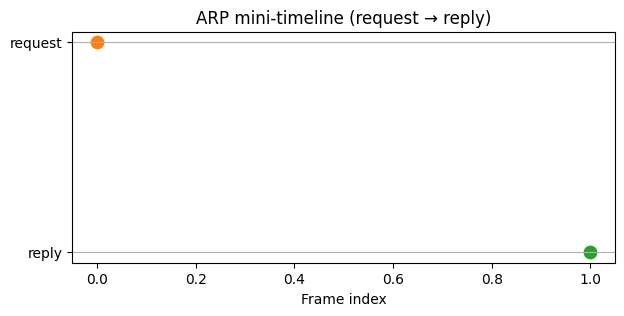

In [17]:
# Simple timeline plot (index as proxy for time in our tiny sample)
plt.figure(figsize=(7,3))
colors = {'request':'tab:orange','reply':'tab:green'}
for r in rows:
    y = 1 if r['op']=='request' else 0
    plt.scatter(r['idx'], y, c=colors[r['op']], s=80)
plt.yticks([0,1],["reply","request"])
plt.xlabel('Frame index'); plt.title('ARP mini-timeline (request → reply)'); plt.grid(True, axis='y'); plt.show()


### 🌐 Broadcast Domain Visualization
We can draw a tiny graph: IP nodes connected via their MACs. Requests fan out (broadcast), replies return (unicast).


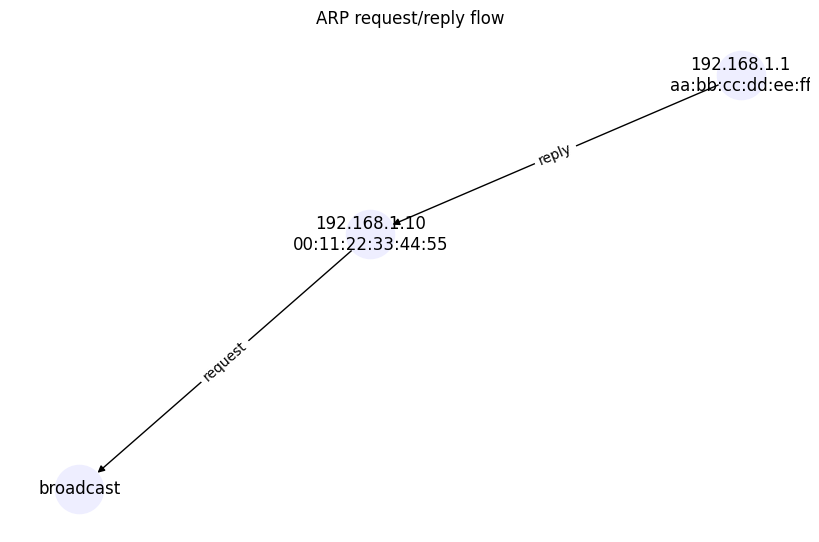

In [18]:
import networkx as nx
G = nx.DiGraph()
for r in rows:
    s = f"{r['src_ip']}\n{r['src_mac']}"
    d = f"{r['dst_ip']}\n{r['dst_mac']}" if not r['l2_broadcast'] else 'broadcast'
    G.add_edge(s, d, label=r['op'])

pos = nx.spring_layout(G, seed=1)
plt.figure(figsize=(8,5))
nx.draw(G, pos, with_labels=True, node_color='#eef', node_size=1200, arrows=True)
edge_labels = nx.get_edge_attributes(G,'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('ARP request/reply flow'); plt.axis('off'); plt.show()


### ✅ Quick Self-Check
1) Which ARP frame is broadcast? Why?  
2) In the reply, which fields bind IP to MAC?  
3) How would a switch treat the broadcast vs the unicast?  
4) How could physical-layer issues from Labs 01–02 break ARP?


## Summary — From Packets to Physics
- ARP requests are broadcast; replies are unicast.  
- This mapping populates the ARP cache, enabling unicast IP traffic.  
- All of it rides on a physical link obeying Nyquist and proper termination; otherwise, frames error and ARP retries increase.